In [19]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp


from keras.models import Sequential
from tensorflow.python.keras.layers import concatenate, Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate, GlobalMaxPooling1D, MaxPooling1D, Flatten, Activation, Reshape, SpatialDropout1D


from training import train, create_training_folder


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [24]:
from data import read_crop_list, prepare_data

df_crops, vocab = read_crop_list()

vocab_size = len(vocab)
# crop_list = np.unique(sample)
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["code"].values.tolist()

(X_train, y_train), (X_test, y_test), (X_val, y_val) = prepare_data()

===Train/validation/test size: 19849, 4963, 6203.


In [29]:
# def model_Conv1D(sequence_length, embeddings):
#     vocab_size, embedding_size = embeddings
#     model = Sequential()
#     model.add(Embedding(vocab_size, embedding_size,
#                         input_length=sequence_length))
#     model.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu'))
#     model.add(MaxPooling1D(2, padding="same"))
#     model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu'))
# #     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(MaxPooling1D(4))
# # #     model.add(Dropout(0.5))
# #     model.add(GlobalMaxPooling1D())
# #     model.add(MaxPooling1D(pool_size=3))
#     model.add(Flatten())
#     model.add(Dense(vocab_size, activation='relu'))
#     model.add(Dense(vocab_size, activation='relu'))
#     return model

def basic_lstm(cat_cols, cat_vocab):
    cat_inputs = []
    crop_inputs = []
    embeddings = []
    embedding_layer_names = []
    cat_emb = []
    for idx, col in enumerate(cat_cols):
        _input = Input(shape=[1], name=col)
        _embed = Embedding(cat_vocab[idx], 10, name=col+'_emb')(_input)
        cat_inputs.append(_input)
        embeddings.append(_embed)
        embedding_layer_names.append(col+'_emb')


    crop_input = Input(shape=(8,))
    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    crop_emb = Embedding(27, 10, input_length=8)(crop_input)

    cat_inputs.append(crop_input)
    embeddings.append(crop_emb)
    embedding_layer_names.append('crop_emb')

    merged_emb =Concatenate(axis=1)(embeddings)
#     merged_emb = concatenate(embeddings)        
    spatial_dropout = SpatialDropout1D(0.2)(merged_emb)
    all_features = Flatten()(spatial_dropout)
        
#     # MLP for classification
#     x = Dropout(0.3)(Dense(256, activation='relu')(all_features))
#     x = Dropout(0.3)(Dense(128, activation='relu')(x))
#     x = Dropout(0.3)(Dense(64, activation='relu')(x))

    output = Dense(27, activation='relu')(all_features)
    model = Model(inputs=cat_inputs + crop_inputs, outputs=output)

    return model   


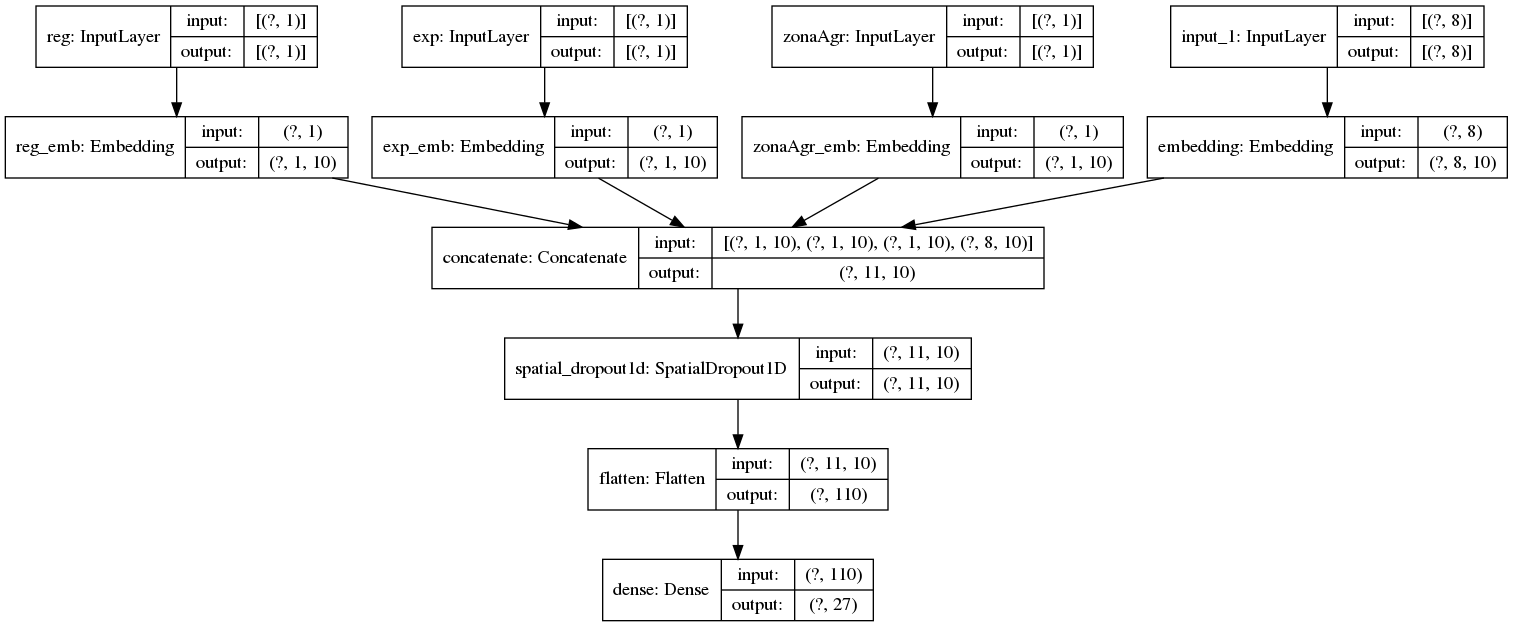

In [30]:
# https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding
cat_cols = ["reg","exp","zonaAgr" ]
cat_vocab = [2, 16766, 9]



K.clear_session()
sequence_length = 16
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = basic_lstm(cat_cols, cat_vocab)

tag = "conv_rest_stacked"

plot_model(model, show_shapes = True)

In [32]:
K.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "conv1d"
folder = create_training_folder(exp_base, tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)

x_train_data = [X_train[:,0],X_train[:,1],X_train[:,2],X_train[:,3:11]]
x_test_data = [X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3:11]]
train(model, x_train_data, y_train, x_test_data, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)

# evaluate
y_hat = model.predict(X_test)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)


Epoch 1/100


ValueError: in user code:

    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 110 but received input with shape [None, 80]


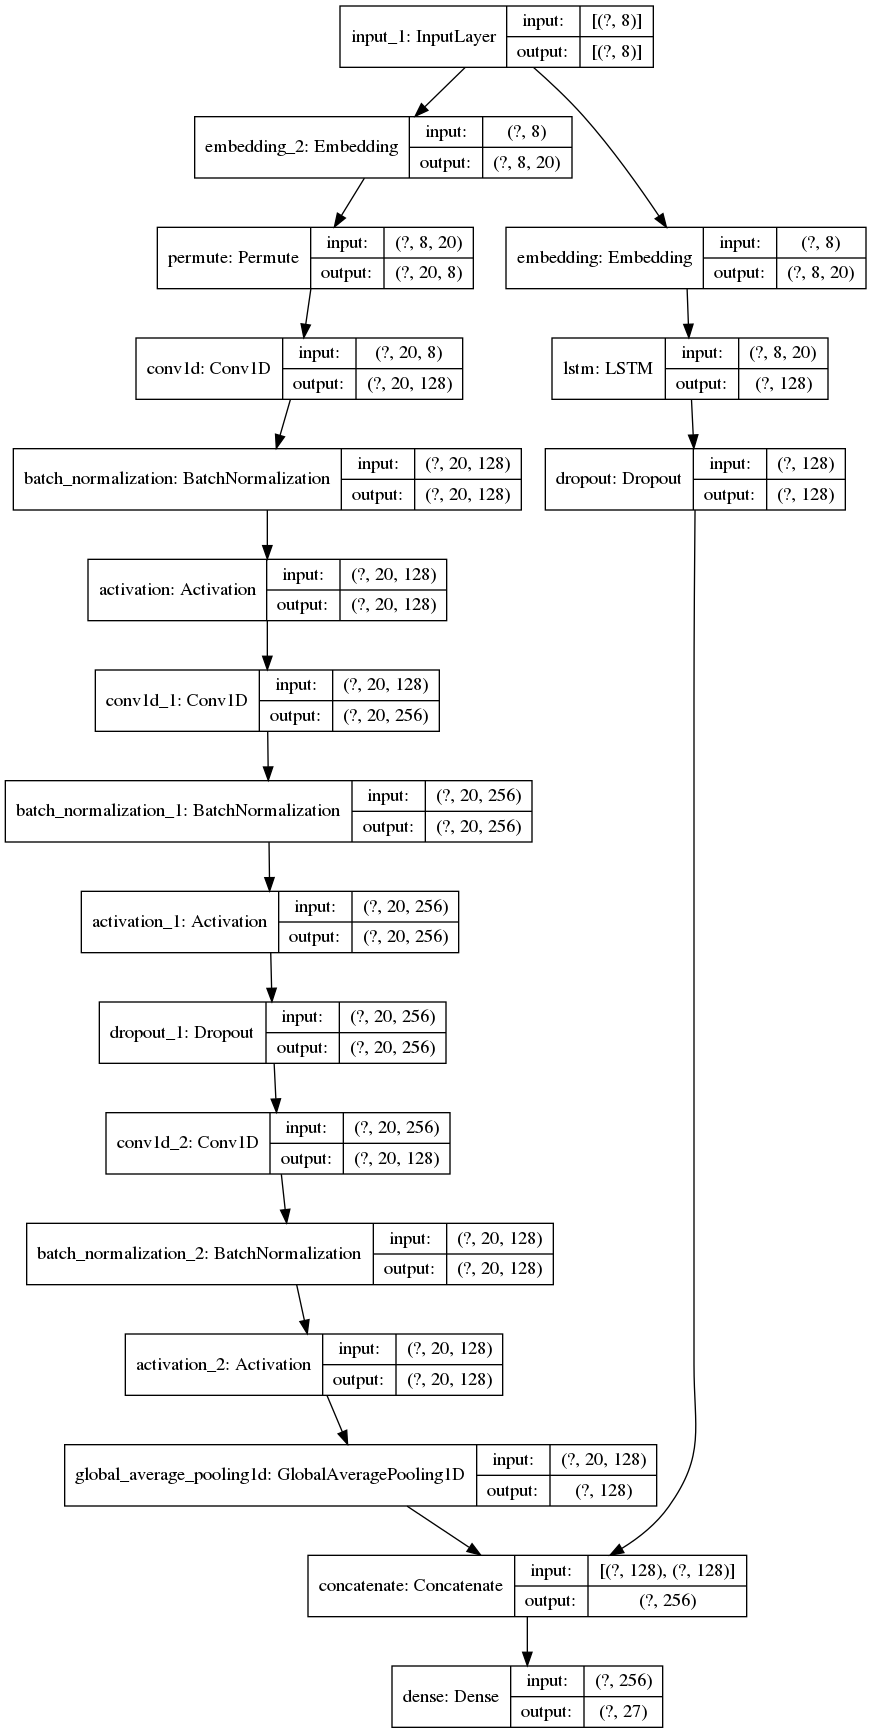

In [80]:
plot_model(model, show_shapes=True)

In [ ]:
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)